In [1]:
import mlflow
import mlflow.sklearn
from mlflow.models import infer_signature
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import datasets
from sklearn.model_selection import train_test_split, GridSearchCV,  KFold, StratifiedKFold, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.feature_selection import SelectKBest, f_classif
import gc
import time
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, confusion_matrix
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from imblearn.pipeline import Pipeline as imbPipeline
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import mlflow
import mlflow.lightgbm
import lightgbm as lgb
import re
from sklearn.preprocessing import LabelEncoder, StandardScaler

## charger les données

In [3]:
data = pd.read_csv("../data/preprocess_table.csv")

## classe déséquilibrée

In [4]:
# Séparer les caractéristiques (X) et les étiquettes (y)
X = data.drop(columns=['TARGET'])
y = data['TARGET']
# summarize class distribution
counter = Counter(y)
print(counter)

Counter({0.0: 282682, 1.0: 24825})


In [5]:
X.shape

(307507, 776)

### traitement des données

In [6]:
# Séparation des données
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [7]:
# imputation
imputer = SimpleImputer(strategy='mean')
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

In [8]:
# Normalisation des données
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [9]:
counter = Counter(y_train)
print(counter)



Counter({0.0: 226145, 1.0: 19860})


In [10]:
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)


In [11]:
train_data

## configurer ML_flow

In [12]:
#définition du serveur de suivi mlflow
mlflow.set_tracking_uri(uri="http://127.0.0.1:5000/")  #équivalent à http://localhost:5000
# le lancer sur un prompt : mlflow server --host 127.0.0.1 --port 5000

### score

In [13]:
# Définir la fonction de coût
def cost_function(y_true, y_pred_prob, threshold, cost_fn=10, cost_fp=1):
    y_pred = (y_pred_prob >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    cost = (fn * cost_fn) + (fp * cost_fp)
    return cost

In [14]:
experiment_name="P7_EJ_score"
mlflow.set_experiment(experiment_name)

<Experiment: artifact_location='mlflow-artifacts:/885410989458547713', creation_time=1744652016843, experiment_id='885410989458547713', last_update_time=1744652016843, lifecycle_stage='active', name='P7_EJ_score', tags={}>

## ligthGBM

In [15]:
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)


In [14]:
'''# Créer un pipeline avec SMOTE et LightGBM
pipeline = imbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('lgbm', lgb.LGBMClassifier(boosting_type='gbdt', objective='binary', metric='auc', random_state=42))
])'''

In [18]:
# Paramètres du modèle
params = {'learning_rate': 0.1,
 'num_leaves': 50,
 'max_depth': 10,
 'min_child_samples': 30,
 'feature_fraction': 0.8,
 'bagging_fraction': 0.8,
 'bagging_freq': 5,
 'reg_alpha': 0.5,
 'reg_lambda': 0.5,
 'scale_pos_weight': 1}

gbm = lgb.train(params, train_data, num_boost_round=100, valid_sets=[test_data])




[LightGBM] [Warning] Unknown parameter: lgbm__learning_rate
[LightGBM] [Warning] Unknown parameter: lgbm__min_child_samples
[LightGBM] [Warning] Unknown parameter: lgbm__num_leaves
[LightGBM] [Warning] Unknown parameter: lgbm__max_depth
[LightGBM] [Warning] Unknown parameter: lgbm__feature_fraction
[LightGBM] [Warning] Unknown parameter: lgbm__scale_pos_weight
[LightGBM] [Warning] Unknown parameter: lgbm__bagging_fraction
[LightGBM] [Warning] Unknown parameter: lgbm__bagging_freq
[LightGBM] [Warning] Unknown parameter: lgbm__reg_lambda
[LightGBM] [Warning] Unknown parameter: lgbm__reg_alpha
[LightGBM] [Warning] Unknown parameter: lgbm__learning_rate
[LightGBM] [Warning] Unknown parameter: lgbm__min_child_samples
[LightGBM] [Warning] Unknown parameter: lgbm__num_leaves
[LightGBM] [Warning] Unknown parameter: lgbm__max_depth
[LightGBM] [Warning] Unknown parameter: lgbm__feature_fraction
[LightGBM] [Warning] Unknown parameter: lgbm__scale_pos_weight
[LightGBM] [Warning] Unknown parameter:

In [19]:
# Démarrer une run MLflow
with mlflow.start_run() as run:
    #  Enregistrer les paramètres du modèle
    mlflow.log_params(params)
    mlflow.log_param("model_type", "LightGBM")

    # Prédire les probabilités
    y_pred_prob = gbm.predict(X_test, num_iteration=gbm.best_iteration)
    # Calculer l'AUC
    auc = roc_auc_score(y_test, y_pred_prob)
    mlflow.log_metric("auc", auc)

    # Optimiser le seuil de décision
    thresholds = np.linspace(0, 1, 100)
    costs = [cost_function(y_test, y_pred_prob, threshold) for threshold in thresholds]
    best_threshold = thresholds[np.argmin(costs)]

    # Enregistrer le meilleur seuil
    mlflow.log_param("best_threshold", best_threshold)

    # Évaluer le modèle avec le meilleur seuil
    y_pred = (y_pred_prob >= best_threshold).astype(int)
    min_cost = min(costs)
    mlflow.log_metric("min_cost", min_cost)

    # Enregistrer le modèle avec un exemple d'entrée pour la signature
    signature = mlflow.models.infer_signature(X_train, gbm.predict(X_train))
    mlflow.lightgbm.log_model(gbm, "LGBM", signature=signature)

    # Enregistrer le modèle dans le Model Registry
    model_uri = f"runs:/{run.info.run_id}/model"
    mlflow.register_model(model_uri, "LGBM_optim")

Registered model 'LGBM_optim' already exists. Creating a new version of this model...
2025/04/15 17:45:53 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LGBM_optim, version 2


🏃 View run chill-tern-275 at: http://127.0.0.1:5000/#/experiments/885410989458547713/runs/11cdf0825c584494992609ef0dae2001
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/885410989458547713


Created version '2' of model 'LGBM_optim'.


In [20]:
model_uri

'runs:/11cdf0825c584494992609ef0dae2001/model'

In [21]:
mlflow.sklearn.save_model(gbm, 'LGBM', signature=signature)

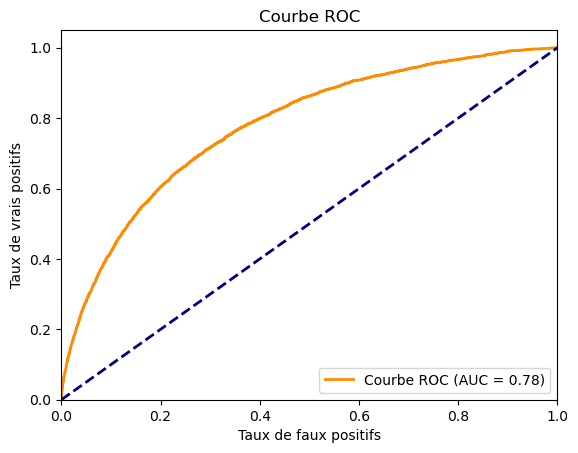

In [22]:
# Tracer la courbe ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Courbe ROC (AUC = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbe ROC')
plt.legend(loc="lower right")
plt.show()

df : échantillon de montableau_entree
fonction = transform df ie lgb.dataset(df)
X =lgb.dataset(df)
curl api.request(X)
dans l'API request